In [1]:
from io import BytesIO
from skimage import io
from PIL import Image, ImageDraw
from skimage import img_as_float
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline 

## 1. Исходное изображение.

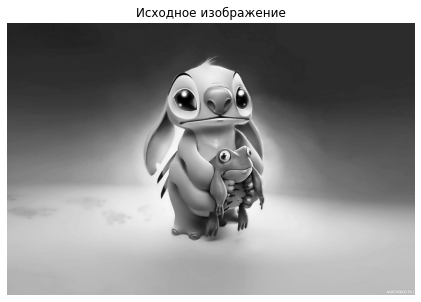

In [6]:
image = cv2.imread('1.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(10,5))
plt.imshow(gray, cmap = 'gray')
plt.title('Исходное изображение')
plt.axis("off")
plt.show()
plt.close()


## 2. Спектр изображения

In [7]:
image1 = cv2.imread('1.jpg', 0)

dft = cv2.dft(np.float32(image1),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])

log_spectr = np.log(magnitude_spectrum)

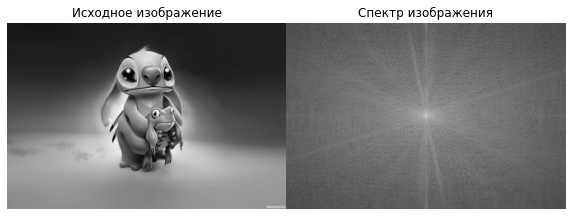

In [8]:
pic_box = plt.figure(figsize=(10, 5 * 2))
pic_box.add_subplot(2, 2, 1)
plt.imshow(image1)
plt.title('Исходное изображение')
plt.set_cmap('gray')
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.axis('off')

pic_box.add_subplot(2, 2, 2)
plt.imshow(log_spectr)
plt.title('Спектр изображения')
plt.set_cmap('gray')
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.axis('off')
plt.show()

## 3. Идеальный фильтр

### 3.1 Для сглаживания

### 3.2 Повышения резкости

## 4. Батерворта


In [15]:
def showImage(images, size = 35, colorMap = 'gray'):
    countImages = len(images)
    #size *= countImages
    pic_box = plt.figure(figsize=(size, size * 5))
    for i, image in enumerate(images):
        pic_box.add_subplot(countImages, 2, i+1)
        plt.imshow(image)
        plt.set_cmap(colorMap)
        plt.subplots_adjust(wspace=0, hspace=0.0)
        plt.axis('off')
    plt.show()

In [16]:
def get_spectr(image):
    f = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    f_shift  =  np.fft.fftshift(f)
    f_complex  = f_shift[:,:,0]  +  1j*f_shift[:,:,1]
    f_abs = np.abs(f_complex)  + 1 # lie between 1 and  le6
    f_bounded = 20 * np.log(f_abs)  # dB
    f_img = 255  * f_bounded  / np.max(f_bounded)
    return f_img.astype(np.uint8)

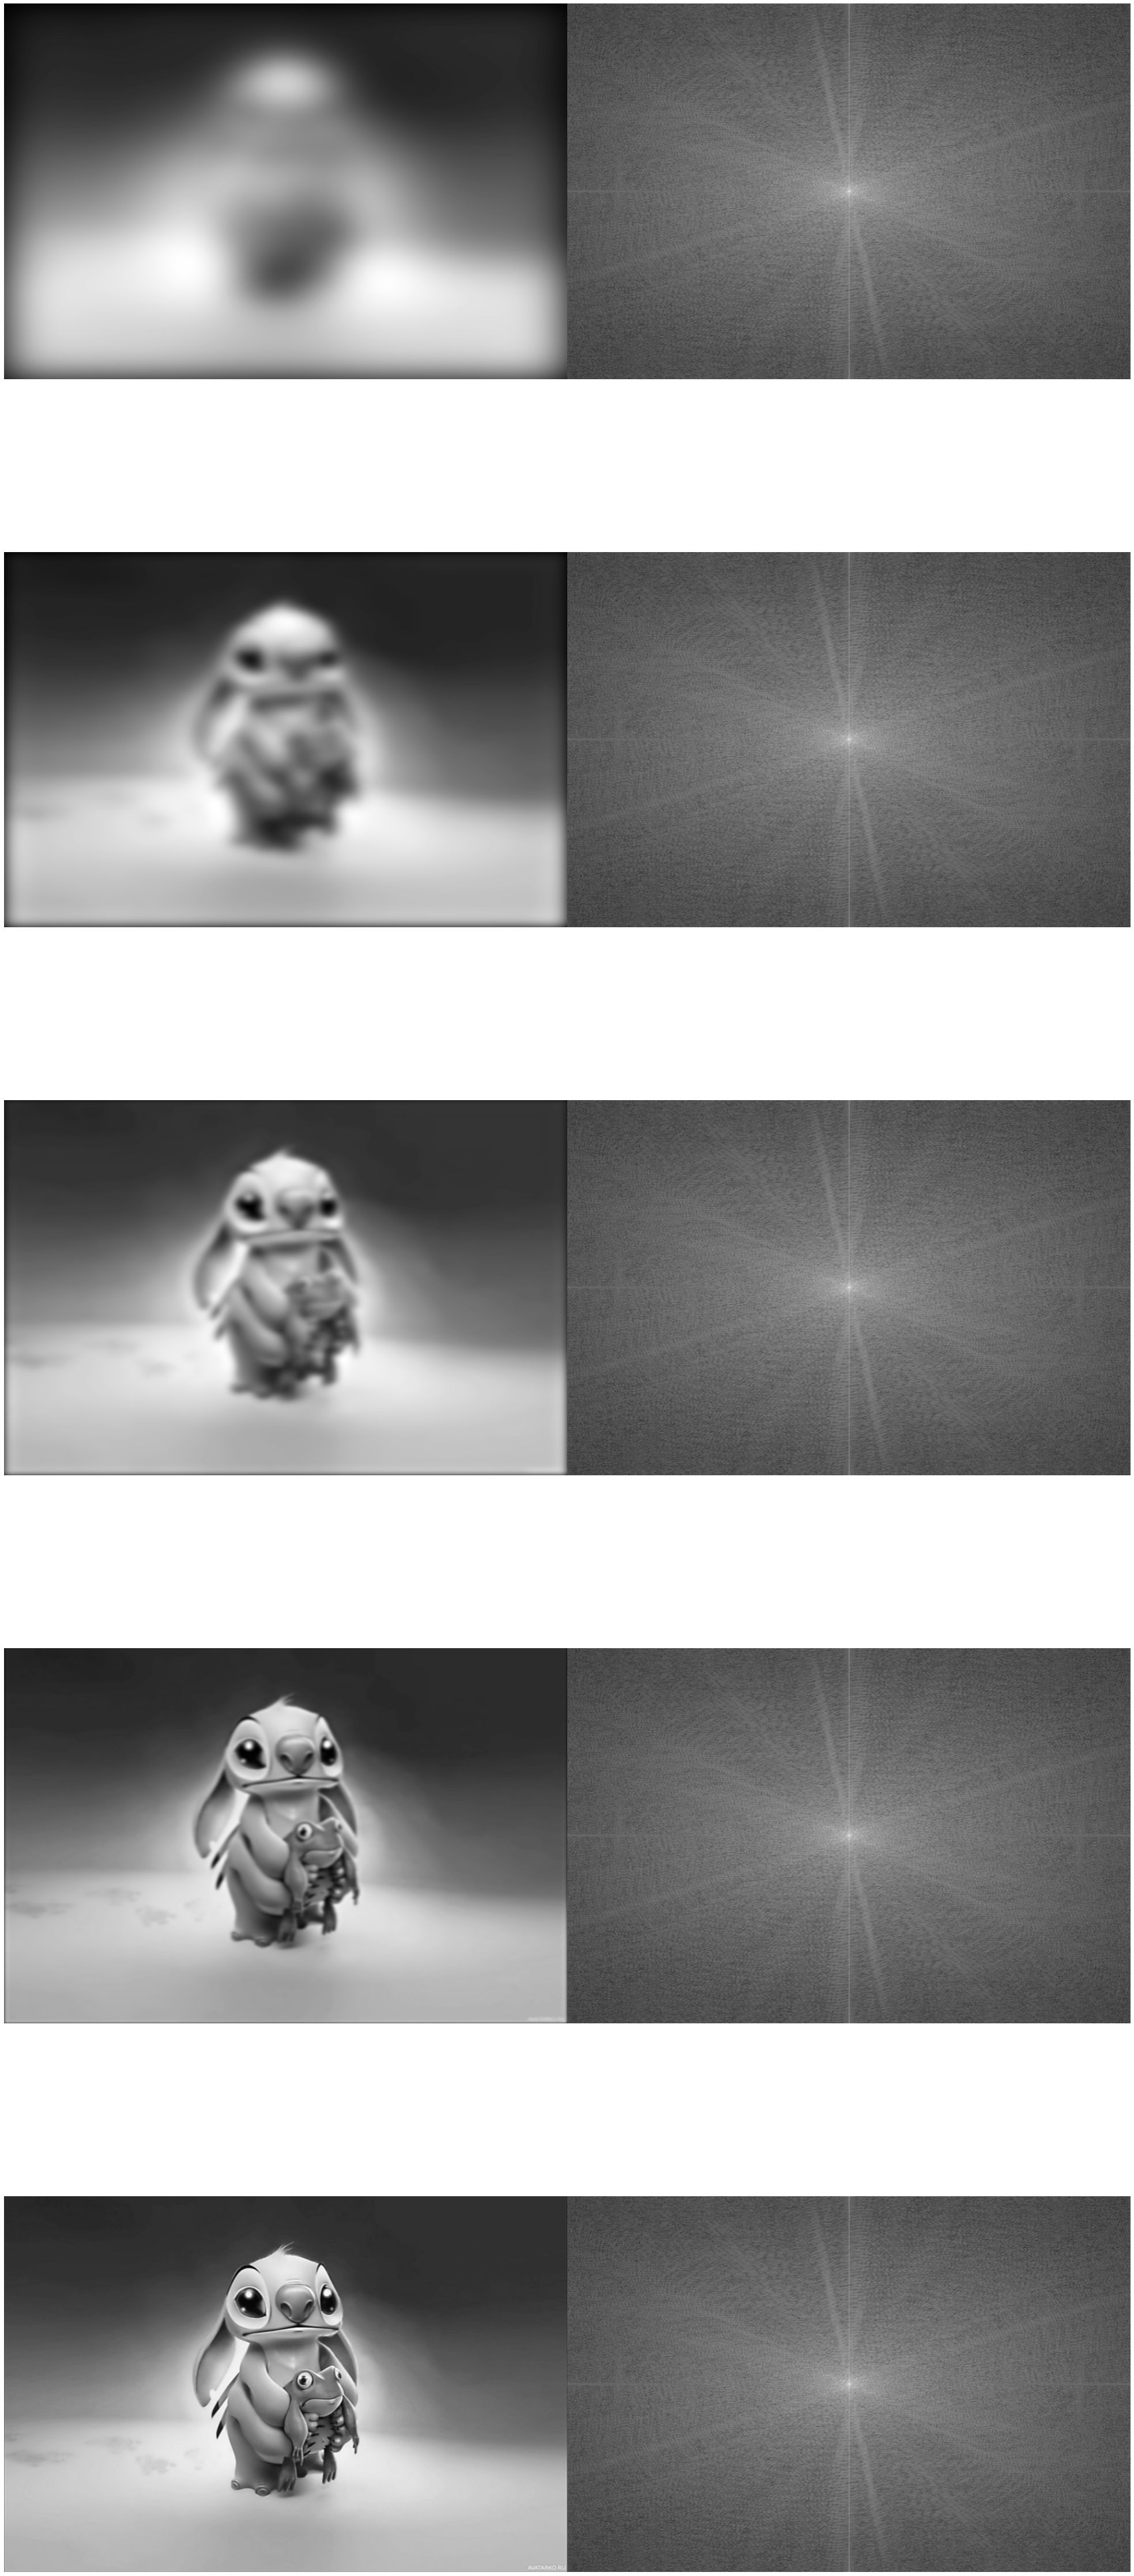

In [17]:
def transform_by_Butterworth(image, d0, n):
    
    height, width = image.shape
    P, Q = height * 2, width * 2
    fp = np.zeros((P, Q), dtype='float')
    for i in range(height):
        for j in range(width):
            fp[i, j] = float(image[i, j]) * (-1) ** (j + i)
            #print(float(gray[i, j]) * (-1) ** (i + j))
    F1 = np.fft.fft2(fp)
    Bw = np.zeros((P, Q), dtype=float)
    
    a = d0 **(2 * n)
    
    for i in range(P):
        for j in range(Q):
            temp = (i-(height+1.0))**2 + (j-(width+1.0))**2
            Bw[i, j] = 1 / (1 + (temp**n) / a)
    
    G = F1 * Bw
    gp = np.fft.ifft2(G)

    image_out = np.zeros((height, width), dtype='uint8')
    
    gp = (gp).real
    g = np.zeros((height, width))
    
    for i in range(height):
        for j in range(width):
            g[i, j] = gp[i, j] * (-1)**(i+j);

    mmax = g.max()
    mmin = g.min()
    r = mmax-mmin
    
    for i in range(height):
        for j in range(width):
            image_out[i, j] = 255 * (g[i, j]-mmin) / r

    return image_out
showImage([transform_by_Butterworth(gray, 10, 2), get_spectr(transform_by_Butterworth(gray, 10, 2)),
           transform_by_Butterworth(gray, 30, 2), get_spectr(transform_by_Butterworth(gray, 30, 2)),
           transform_by_Butterworth(gray, 60, 2), get_spectr(transform_by_Butterworth(gray, 60, 2)),
           transform_by_Butterworth(gray, 160, 2), get_spectr(transform_by_Butterworth(gray, 160, 2)),
           transform_by_Butterworth(gray, 460, 2), get_spectr(transform_by_Butterworth(gray, 160, 2))
          ])